[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/19wH8AUdOv5A636UPOTs4vQfFWeXhHqPx?usp=sharing)

## Introduction to CLIP and Multimodal Models

### Programming with CLIP

Let’s look at the power of CLIP through a simple programming example. We will take three different images of cats from Unsplash. Let’s display these.

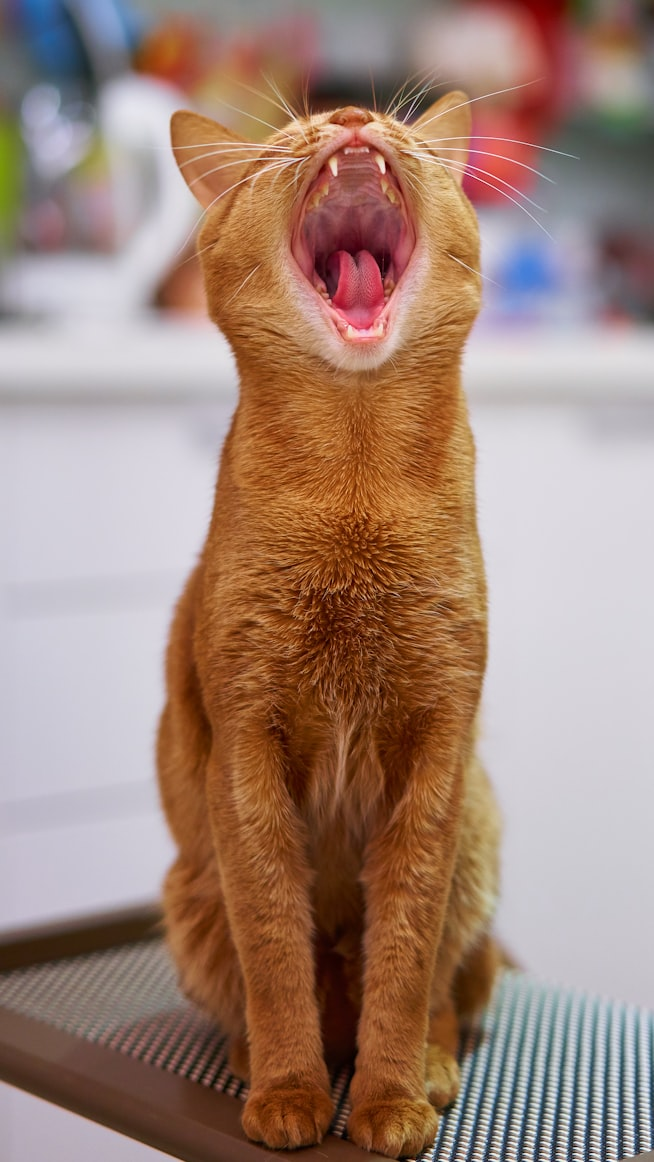

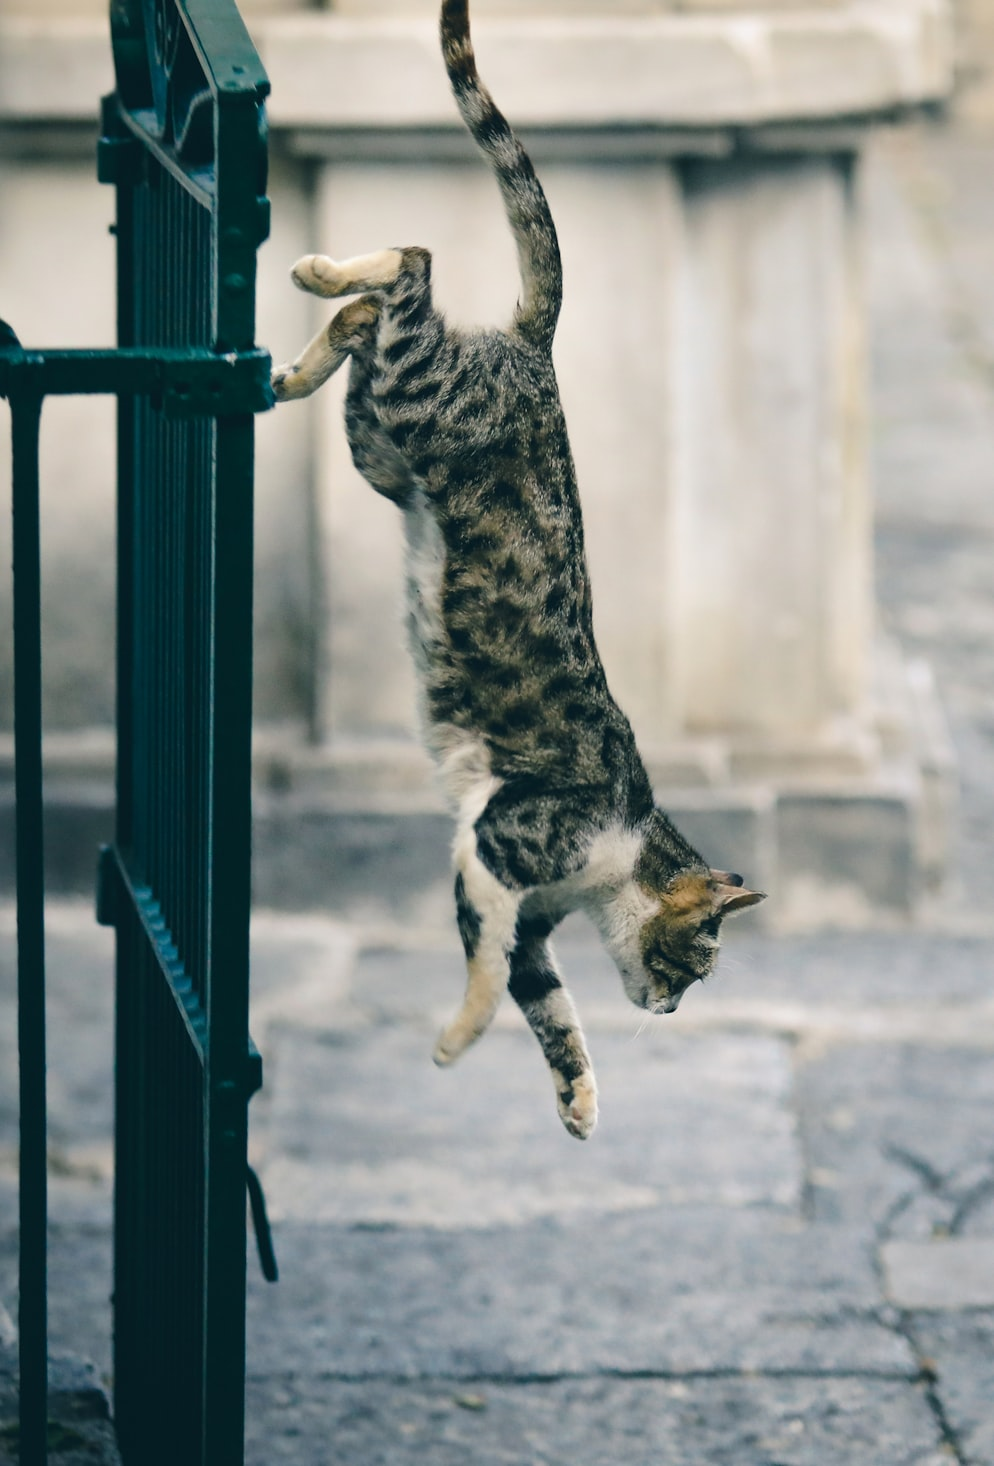

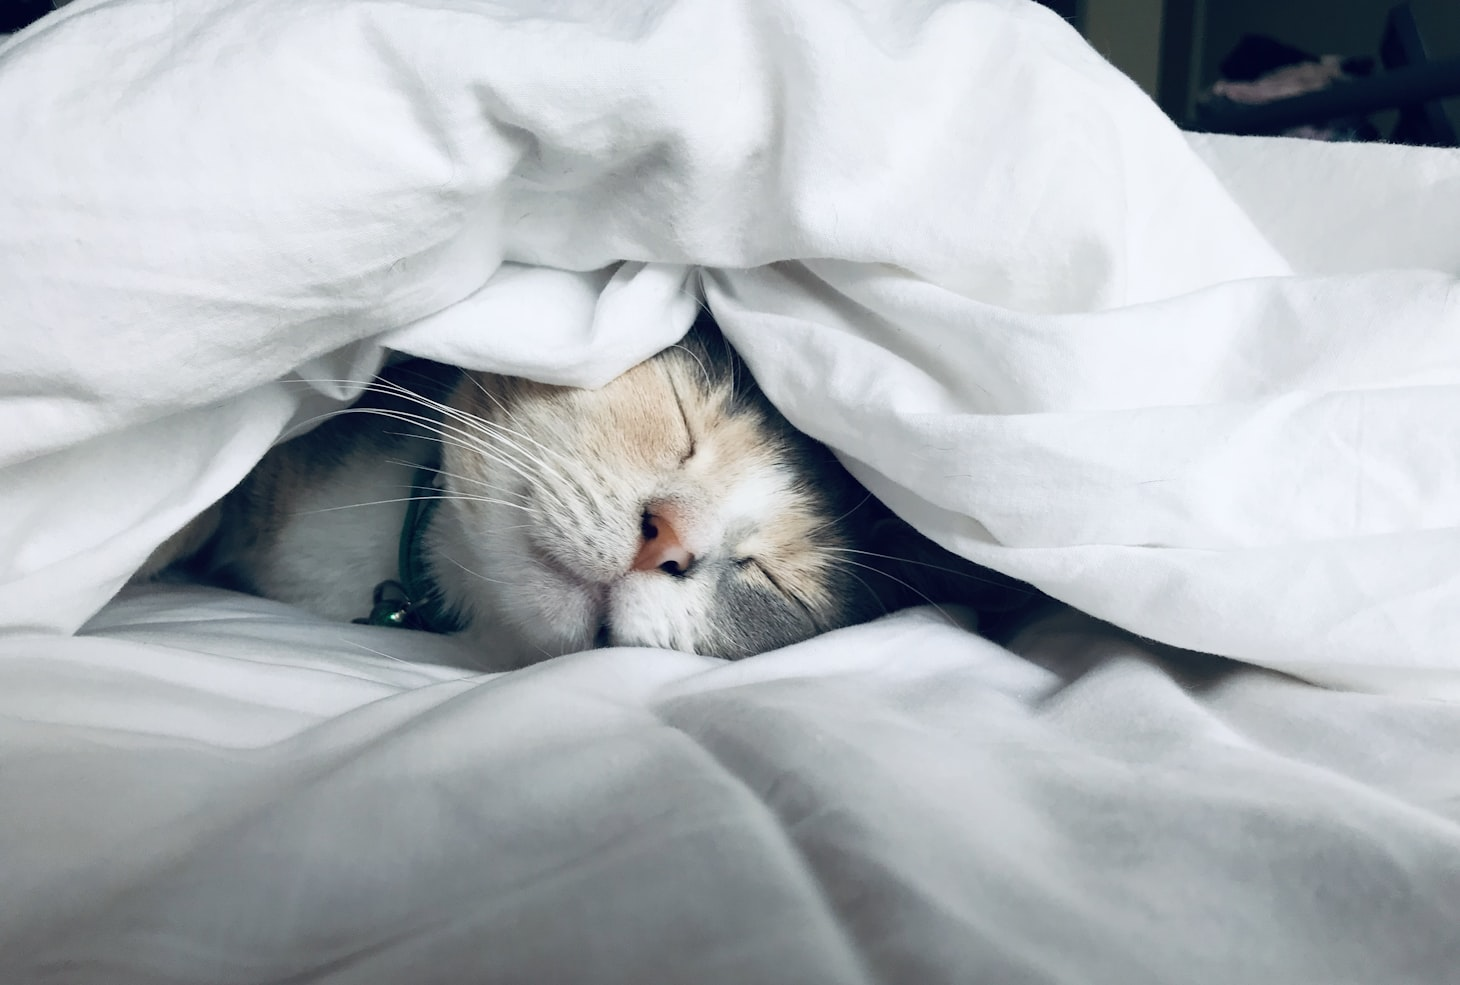

In [ ]:
# Import relevant modules
from PIL import Image
from IPython.display import display
from io import BytesIO
from transformers import CLIPProcessor, CLIPModel
import requests
import matplotlib.pyplot as plt
import numpy as np

# Create a list of urls. These are the urls corresponding to the images of the cats.
urls = [
    "https://images.unsplash.com/photo-1580280949881-ca923b8afda4?q=80&w=654&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://images.unsplash.com/photo-1566513317351-c6d7be11505e?q=80&w=994&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
    "https://images.unsplash.com/photo-1541781774459-bb2af2f05b55?q=80&w=1460&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
]

#  Take a list of image URLs, download each image, and open them
images = [Image.open(BytesIO(requests.get(url).content)) for url in urls]

# Display images
for image in images:
    display(image)

We want to generate embeddings for these images so we can use the CLIP (Contrastive Language–Image Pre-training) model. We load `CLIPModel` to generate the embeddings and `CLIPProcessor` for preprocessing (e.g. resizing images, etc.).

We create the model and processor. Specifically, we use OpenAI’s model `clip-vit-base-patch32` [7].

In [ ]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

We already have the images stored in the variable `images`. So, all that’s left is to create captions. We will create a list of captions containing the true captions as well as fake ones.

In [ ]:
captions = ["a cat sleeping",
            "a cat yawning",
            "a cat jumping",
            "a motorbike on a road",
            "rainbow in the sky",
            "a water bottle"]

We now process the captions and images as follows:

In [ ]:
# Process captions and images
inputs = processor(
    text=captions,         # input the captions
    images=images,         # inputs the images
    return_tensors='pt',   # returns pytorch tensors
    padding=True           # ensures sequences all the same length
)

All that’s left to do is get the predictions and display the results! Let’s get the predictions first.

In [ ]:
# Get predictions
outputs = model(**inputs)
probs = outputs.logits_per_image.argmax(dim=1)

Now we can display the images with their corresponding predicted captions.

Predicted Caption: a cat yawning


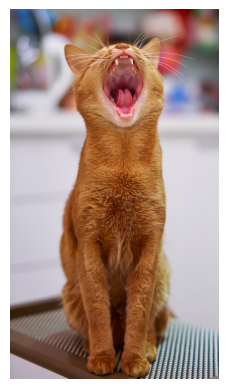

Predicted Caption: a cat jumping


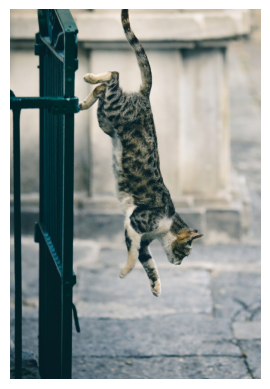

Predicted Caption: a cat sleeping


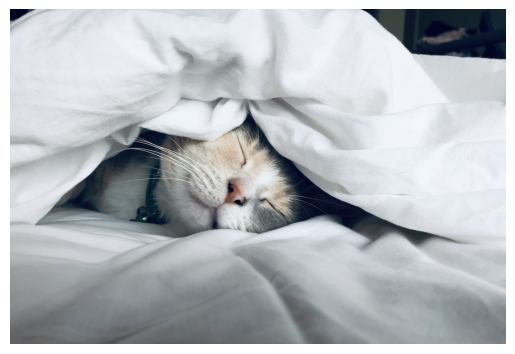

In [ ]:
# Display images with predicted captions
for i, image in enumerate(images):
    argmax = probs[i].item()
    print(f"Predicted Caption: {captions[argmax]}")
    plt.imshow(np.asarray(image))
    plt.axis('off')
    plt.show()

Pretty cool!

### Programming with [Marqo](https://www.marqo.ai/)'s GCL

Let's take a look at Marqo's GCL in action.

First, we install relevant modules

In [ ]:
# Stops output in Colab. Remove this if you wish.
%%capture

! pip install open_clip_torch
! pip install wget

Let's take an image of a pair of Oxford shoes and display it below.

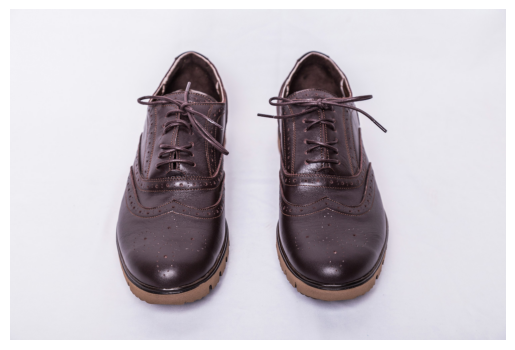

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Define the URL of the image
image_url = "https://images.unsplash.com/photo-1673201183171-0884d985b81d?q=80&w=2970&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

# Download the image
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


Now, let's take this image along with three captions:
* "A dog"
* "Vintage Style Women's Oxfords"
* "A cat"

The idea is that we will use GCL to generate scores for each of these captions when compared to the image. We will expect captions 1 and 3 to be low as, indeed, the image is not a picture of a cat or dog. Caption 2 will hopefully have the highest score as they are indeed, Oxford shoes. However, they are men’s shoes and not necessarily vintage. This is something GCL will be able to pick up on and so, we expect a higher score compared to captions 1 and 3.

Let's see what we get!

In [ ]:
import torch
import open_clip
import wget

# Download the model
model_url = "https://marqo-gcl-public.s3.us-west-2.amazonaws.com/v1/gcl-vitb32-117-gs-full-states.pt"
wget.download(model_url, "gcl-vitb32-117-gs-full-states.pt")
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='gcl-vitb32-117-gs-full-states.pt')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# Preprocess the image
image = preprocess(image).unsqueeze(0)

# Tokenize the text
text = tokenizer(["a dog", "Vintage Style Women's Oxfords", "a cat"])
logit_scale = 10

# Calculate the features and probabilities
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (logit_scale * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)


Label probs: tensor([[0.0997, 0.7586, 0.1418]])


Awesome, we get the results:
* A dog: `0.0997`
* Vintage Style Women's Oxfords: `0.7586`
* A cat: `0.1418`

We can see that GCL clearly knows the image is not a cat or a dog due to the low scores associated with those captions. It clearly identifies the shoes are Oxfords with a score of `0.7586`. This score also suggests GCL was able to understand the shoes were mens rather than womens and were not necessarily vintage.

Pretty cool! If you want to try out GCL for yourself, visit our [repository here](https://github.com/marqo-ai/GCL) with more information.